## Parrish et al paralog GI screen

**Discovery of synthetic lethal and tumor suppressive paralog pairs in the human genome**

https://www.biorxiv.org/content/10.1101/2020.12.20.423710v1

**Input**: Supplemental Table 3. PC9 and HeLa screen paralog genetic interaction (GI) scores and other relevant paralog annotations.

**Output**: Paralog pairs from screen annotated with SL status

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import os

get_data_path = lambda folders, fname: os.path.normpath(os.environ['3RD_PARTY_DIR']+'/'+'/'.join(folders) +'/'+ fname)
get_local_data_path = lambda folders, fname: os.path.normpath('../../local_data/' +'/'.join(folders) +'/'+ fname)

# Supplementary Table 3: PC9 and HeLa screen paralog genetic interaction (GI) scores and other relevant paralog annotations.
file_data = get_data_path(['GI_screens', 'parrish_2020'], 'media-1.xlsx')
file_all_pairs = lambda ens_v: get_local_data_path(['processed', 'ensembl'+ens_v], 'all_pairs.csv')

# Output
file_parrish_pairs = get_local_data_path(['processed','screen_pairs'], 'parrish_pairs.csv')

### Process data from supplement Table 3

In [2]:
raw_data = pd.read_excel(file_data, sheet_name='Table_3', skiprows=1)

In [3]:
raw_data[:2]

,paralog_pair,PC9_GI_score_rank,PC9_GI_score,PC9_GI_fdr,HeLa_GI_score_rank,HeLa_GI_score,HeLa_GI_fdr,target1,target2,target1_ensembl_id,...,HeLa_target2_cn,HeLa_DKO_expected_CS,HeLa_DKO_observed_CS,HeLa_GI_pval,PC9_GI_flag,HeLa_GI_flag,GI_flag,same_chr,same_chr_dist,proximity
0,CCNL2|CCNL1,1,-2.313788,0.000165,10,-1.261084,0.026168,CCNL2,CCNL1,ENSG00000221978,...,1.870128,-0.099315,-1.332104,0.001626,SL_in_PC9,SL_in_HeLa,synthetic_lethal,False,NaN,diff_chr
1,CDK6|CDK4,2,-1.537568,0.000340,210,-0.251834,0.307389,CDK6,CDK4,ENSG00000105810,...,1.854469,-0.451694,-0.632285,0.119673,SL_in_PC9,neither_in_HeLa,synthetic_lethal,False,NaN,diff_chr


In [4]:
# SL interactions are called for: GI < -0.5 and FDR <0.1
# Preprint says 87 SLs in PC9 and 70 SLs in HeLa, 122 SL in at least 1 context
print('N SL in PC9:', raw_data[(raw_data.PC9_GI_score < -0.5) & (raw_data.PC9_GI_fdr < 0.1)].shape[0], '/', raw_data.shape[0])
print('N SL in HeLa:', raw_data[(raw_data.HeLa_GI_score < -0.5) & (raw_data.HeLa_GI_fdr < 0.1)].shape[0], 
      '/', raw_data.shape[0])

N SL in PC9: 87 / 1030
N SL in HeLa: 70 / 1030


#### Identify hits

In [5]:
# Call pair SL on a cell line specific basis
all_screen_pairs = raw_data.assign(PC9_SL = (raw_data.PC9_GI_score < -0.5) & (raw_data.PC9_GI_fdr < 0.1),
                                   HeLa_SL = (raw_data.HeLa_GI_score < -0.5) & (raw_data.HeLa_GI_fdr < 0.1))
all_screen_pairs['n_SL'] = all_screen_pairs[['PC9_SL','HeLa_SL']].sum(axis=1)

# Check that this matches with annotations
assert(all_screen_pairs[all_screen_pairs.PC9_GI_flag=='SL_in_PC9'].shape[0] == sum(all_screen_pairs.PC9_SL))
assert(all_screen_pairs[all_screen_pairs.HeLa_GI_flag=='SL_in_HeLa'].shape[0] == sum(all_screen_pairs.HeLa_SL))
print('N pairs with SL flag:', all_screen_pairs[all_screen_pairs.GI_flag=='synthetic_lethal'].shape[0])

# Rename for merging with our Ensembl list
all_screen_pairs = all_screen_pairs.rename(columns={'target1_ensembl_id':'A1_ensembl', 'target2_ensembl_id':'A2_ensembl'})

all_screen_pairs[:2]

N pairs with SL flag: 122


,paralog_pair,PC9_GI_score_rank,PC9_GI_score,PC9_GI_fdr,HeLa_GI_score_rank,HeLa_GI_score,HeLa_GI_fdr,target1,target2,A1_ensembl,...,HeLa_GI_pval,PC9_GI_flag,HeLa_GI_flag,GI_flag,same_chr,same_chr_dist,proximity,PC9_SL,HeLa_SL,n_SL
0,CCNL2|CCNL1,1,-2.313788,0.000165,10,-1.261084,0.026168,CCNL2,CCNL1,ENSG00000221978,...,0.001626,SL_in_PC9,SL_in_HeLa,synthetic_lethal,False,NaN,diff_chr,True,True,2
1,CDK6|CDK4,2,-1.537568,0.000340,210,-0.251834,0.307389,CDK6,CDK4,ENSG00000105810,...,0.119673,SL_in_PC9,neither_in_HeLa,synthetic_lethal,False,NaN,diff_chr,True,False,1


#### Merge with our Ensembl pairs

In [6]:
all_pairs_93 = pd.read_csv(file_all_pairs('93'))[['A1','A2','A1_ensembl','A2_ensembl']]
print('N=', all_pairs_93.shape[0])
all_pairs_102 = pd.read_csv(file_all_pairs('102'))[['A1','A2','A1_ensembl','A2_ensembl']]
print('N=', all_pairs_102.shape[0])

N= 73296
N= 179968


In [7]:
# Merge with Ensembl list of paralog pairs (both versions), on Ensembl ID
overlap_93 = pd.merge(all_pairs_93[['A1','A2','A1_ensembl','A2_ensembl']], all_screen_pairs)
overlap_102 = pd.merge(all_pairs_102[['A1','A2','A1_ensembl','A2_ensembl']], all_screen_pairs)
print('Overlap w/ Ens.93:', overlap_93.shape[0])
print('Overlap w/ Ens.102:', overlap_102.shape[0])

# Combine both merges to get pairs in either Ensembl version
screen_pairs = pd.merge(overlap_93, overlap_102, how='outer', indicator='in_version')
screen_pairs = screen_pairs.assign(in_93 = ((screen_pairs.in_version=='both') | (screen_pairs.in_version=='left_only')),
                                   in_102 = ((screen_pairs.in_version=='both') | (screen_pairs.in_version=='right_only')))

screen_pairs['sorted_gene_pair'] = screen_pairs.apply(lambda x: '_'.join(sorted([x.A1, x.A2])), axis=1)
screen_pairs = screen_pairs[['sorted_gene_pair','A1','A2','PC9_SL','HeLa_SL','n_SL','in_93','in_102']]
screen_pairs[:1]

Overlap w/ Ens.93: 1027
Overlap w/ Ens.102: 1015


,sorted_gene_pair,A1,A2,PC9_SL,HeLa_SL,n_SL,in_93,in_102
0,A2M_PZP,A2M,PZP,False,False,0,True,True


#### Num hits

In [10]:
print('SL in 1+: %d = %.2f%%' % (sum(screen_pairs.n_SL >= 1), sum(screen_pairs.n_SL >= 1)/screen_pairs.shape[0]*100))
print('SL in 2: %d = %.2f%%' % (sum(screen_pairs.n_SL == 2), sum(screen_pairs.n_SL == 2)/screen_pairs.shape[0]*100))
screen_pairs[:2]

SL in 1+: 122 = 11.87%
SL in 2: 35 = 3.40%


,sorted_gene_pair,A1,A2,PC9_SL,HeLa_SL,n_SL,in_93,in_102
0,A2M_PZP,A2M,PZP,False,False,0,True,True
1,F11_KLKB1,F11,KLKB1,True,False,1,True,True


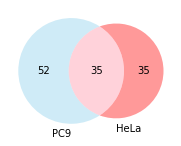

In [11]:
f, ax = plt.subplots(figsize=(3,3))
v = venn2([set(screen_pairs[screen_pairs.PC9_SL]['sorted_gene_pair']), 
           set(screen_pairs[screen_pairs.HeLa_SL]['sorted_gene_pair'])], ['PC9','HeLa'], ax=ax, set_colors=['skyblue','red'])
for text in v.set_labels: text.set_fontsize(10)

In [14]:
screen_pairs.drop(columns=['A1','A2']).to_csv(file_parrish_pairs, index=0)